In [1]:
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from feature_engine.discretisation import ArbitraryDiscretiser
import math
import pandas as pd
import numpy as np
import streamlit as st
from joblib import dump 
import joblib




df = pd.read_csv('dataset2.csv')

print(df.head(), df.shape)
# separation des features et de la variable cible
X = df.drop('charges', axis=1)
y = df[['charges']]
print(f'''verif des dimensions X et Y
      X (dataset sans la variable cible): {X.shape}
      Y (la variable cible) : {y.shape}''')


# division du dataset en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])
print(f''' verif du split 80 20 
80% du dataset : X train -> {X_train.shape}, Y train -> {y_train.shape}
# 20% du dataset : X test -> {X_test.shape}, Y test -> {y_test.shape}''')


   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520 (1337, 7)
verif des dimensions X et Y
      X (dataset sans la variable cible): (1337, 6)
      Y (la variable cible) : (1337, 1)
 verif du split 80 20 
80% du dataset : X train -> (1136, 6), Y train -> (1136, 1)
# 20% du dataset : X test -> (201, 6), Y test -> (201, 1)


In [2]:
# function custom
def log_transform(x):
    return np.log(x + 1)

def custom_bmi_discretizer(df):
    custom_bins = [0, 30, 100, float('inf')]
    bmi_discretizer = ArbitraryDiscretiser(binning_dict={'bmi': custom_bins}, return_object=True)
    df[['bmi']] = bmi_discretizer.fit_transform(df[['bmi']])
    return df

log_transformer = FunctionTransformer(log_transform)
bmi_discretizer_transformer = FunctionTransformer(custom_bmi_discretizer)

#### ======= preprocessing
#processeur pour split le bmi 
preprocessor_bmi = Pipeline(steps=[
    ('bmi_discretize', bmi_discretizer_transformer)
])

#processeur pour les colonnes numériques 
preprocessor_num = Pipeline(steps=[
    ('log', FunctionTransformer(log_transform)),
])
#processeur pour les colonnes catégorielles 
preprocessor_cat = Pipeline(steps=[
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('bmi', preprocessor_bmi, ['bmi']),
        ('num', preprocessor_num, ['age', 'bmi', 'children']),
        ('cat', preprocessor_cat, ['region', 'sex', 'smoker'])
    ]
)

In [3]:
#creation pipeline lasso
pipeline_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('regression', Lasso())
])

#test de différents hyperparam d'alpha pour le lasso
param_grid_lasso = {
    'regression__alpha': np.arange(5,10,0.1),
    'regression__precompute': [True],
    'regression__max_iter': [5000],
    
}

### grid search
grid_lasso = GridSearchCV(pipeline_lasso, param_grid_lasso, cv=5)

# eviter data leakage -> entraîner le pipeline sur les données d'entraînement 
grid_lasso.fit(X_train, y_train)
best_model = grid_lasso.best_estimator_
#puis predire y sur l'ensemble de test avec le meme pipeline
y_pred = best_model.predict(X_test)
# print(y_pred)

c:\Users\socci\Desktop\DEVIA\brief_assurance_reg\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14418890.433174133, tolerance: 13974848.585028803
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\socci\Desktop\DEVIA\brief_assurance_reg\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13374863.96661377, tolerance: 12712696.685221957
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\socci\Desktop\DEVIA\brief_assurance_reg\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14410910.187610626, tolerance: 13974848.585028803
  model = cd_fast.enet_coordinate_descent_gram(
c:

In [4]:
#test des les differents metriques sur modele lasso
#comparaison du y prédit avec le y de test
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error du modèle lasso: {mse}')

r2 = r2_score(y_test, y_pred)

print(f'Coefficient de determination R² du modèle lasso: {r2}')

rmse = math.sqrt(mse)
print(f'Root Mean Squared Error (RMSE) du modèle lasso: {rmse} \n rappel moyenne charge : 13279')

Mean Squared Error du modèle lasso: 10745231.228894157
Coefficient de determination R² du modèle lasso: 0.9258518942009731
Root Mean Squared Error (RMSE) du modèle lasso: 3277.9919507061268 
 rappel moyenne charge : 13279


In [5]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('bmi',
                                                  Pipeline(steps=[('bmi_discretize',
                                                                   FunctionTransformer(func=<function custom_bmi_discretizer at 0x000001567347EA70>))]),
                                                  ['bmi']),
                                                 ('num',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<function log_transform at 0x00000156325CA0E0>))]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['region', 'sex',
                                                   'smoker'])])),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('regression',
                 Lasso(alpha=5.0, max_iter=5000, precompute=True))])

In [6]:
# extration  modèle Lasso
lasso_model = best_model.named_steps['regression']

# obtention des coefficients
coefficients = lasso_model.coef_
coefficients

for idx, coef in enumerate(sorted(coefficients, key=abs, reverse=True)):
    print(f"Coefficient {idx + 1}: {coef}")

Coefficient 1: 21664.66294004536
Coefficient 2: -18084.44037518703
Coefficient 3: -8364.458055055507
Coefficient 4: 5346.490936036396
Coefficient 5: 3638.9474972760568
Coefficient 6: 2094.699453134048
Coefficient 7: -1748.157551269395
Coefficient 8: 1638.5987879261043
Coefficient 9: 1530.6410209197497
Coefficient 10: 1473.6894083144641
Coefficient 11: -1182.5407890626516
Coefficient 12: 979.4794837843609
Coefficient 13: -582.2472694271803
Coefficient 14: 389.7785969168393
Coefficient 15: 359.8175363888774
Coefficient 16: 339.9846463977849
Coefficient 17: -290.6766574508347
Coefficient 18: 233.55829983340757
Coefficient 19: -214.38971830691122
Coefficient 20: -191.57018898180496
Coefficient 21: -190.47694986749048
Coefficient 22: 189.44086099311235
Coefficient 23: -164.375920077825
Coefficient 24: -141.98401028607373
Coefficient 25: 138.6243715702276
Coefficient 26: 119.78090553646535
Coefficient 27: 110.07972892099
Coefficient 28: -97.20508047517417
Coefficient 29: -77.84394362046619
C

In [7]:
new_data = pd.DataFrame({
    'age': [35, 40, 30, 60,60],  
    'sex': ['female', 'male', 'male', 'female','female'],  
    'bmi': [22.5, 30.0, 25.0, 47,50],
    'children': [1, 2, 0, 5,5],
    'smoker': ['yes', 'no', 'no', 'yes','yes'],  
    'region': ['southwest', 'northeast', 'southeast', 'southeast', 'southeast'],
})

# faire des prédictions avec le modèle optimisé
new_y_ped = best_model.predict(new_data)

# ajouter les prédictions à new_data
new_data['predicted_charges'] = new_y_ped

print(new_data)

   age     sex   bmi  children smoker     region  predicted_charges
0   35  female  22.5         1    yes  southwest       18896.449632
1   40    male  30.0         2     no  northeast        9937.332463
2   30    male  25.0         0     no  southeast        4019.235805
3   60  female  47.0         5    yes  southeast       52015.948361
4   60  female  50.0         5    yes  southeast       52553.896853


In [8]:
import pickle
with open('best_model.pkl', 'wb') as fichier:
    pickle.dump(best_model, fichier)

c:\Users\socci\Desktop\DEVIA\brief_assurance_reg\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2378499.558596015, tolerance: 1290442.0251568267
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\socci\Desktop\DEVIA\brief_assurance_reg\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36905189.02576923, tolerance: 2909821.405952846
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\socci\Desktop\DEVIA\brief_assurance_reg\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14946717.206939697, tolerance: 4132997.6564295692
  model = cd_fast.enet_coordinate_descent_gram(
c:\U

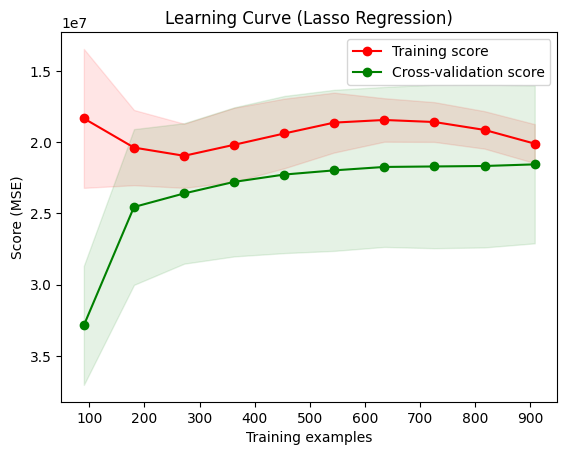

In [9]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = best_model,
    X = X_train,
    y = y_train,
    train_sizes = np.linspace(0.1, 1.0, 10),
    cv = 5,
    scoring = 'neg_mean_squared_error'
)

# Calculating mean and standard deviation for training and validation scores
train_scores_mean = -train_scores.mean(axis = 1)
train_scores_std = train_scores.std(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
validation_scores_std = validation_scores.std(axis = 1)

plt.figure()
plt.title("Learning Curve (Lasso Regression)")
plt.xlabel("Training examples")
plt.ylabel("Score (MSE)")
plt.gca().invert_yaxis()

# Plotting the learning curve
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="g")

plt.legend(loc="best")
plt.show()